# Installing Necessary Dependencies

In [1]:
! pip install -q -U bitsandbytes
! pip install -q -U transformers
! pip install -q -U peft
! pip install -q -U accelerate
! pip install -q -U datasets
! pip install -q -U wandb
! pip install -q -U trl

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import wandb
import tqdm
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time
import seaborn as sns
from datasets import Dataset
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import torch.nn.functional as F
from peft import (
    LoraConfig, 
    PeftConfig, 
    LoraConfig, 
    TaskType, 
    PeftModel, 
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    BitsAndBytesConfig,
    TrainingArguments,
    TrainerCallback,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix, 
    f1_score,  
    precision_score, 
    recall_score
)
from trl import SFTTrainer,setup_chat_format
from kaggle_secrets import UserSecretsClient

In [3]:
user_secrets=UserSecretsClient()
wandb_key=user_secrets.get_secret("wandb_api_key")
username=user_secrets.get_secret("hf_username")
repository_name = user_secrets.get_secret("hf_repo")
token=user_secrets.get_secret('hf_api_token')
os.environ['HUGGINGFACE_TOKEN'] = token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
! wandb login $wandb_key
! huggingface-cli login --token $HUGGINGFACE_TOKEN

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Loading Quantized [Google/Flan-T5](https://huggingface.co/google/flan-t5-base) Model

In [4]:
# Measure time to prepare model and tokenizer
time_start = time()

# Define model ID and compute data type
model_id = 'google/flan-t5-base'
compute_dtype = torch.bfloat16

# Configure BitsAndBytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True
)

# Load model configuration
model_config = AutoConfig.from_pretrained(
    model_id,
    trust_remote_code=True,
    max_new_tokens=1024
)


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the Flan-T5 model
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,  # Use quantization if specified
    device_map='auto',  # Automatically map the model to available devices
)

# Setup chat format and prepare for k-bit training
model, tokenizer = setup_chat_format(model, tokenizer)  # Ensure this function is defined
model = prepare_model_for_kbit_training(model)  # Ensure this function is defined

# Measure and print the time taken to prepare the model and tokenizer
time_end = time()
print(f"Time to prepare model and tokenizer: {round(time_end - time_start, 3)} sec.")

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Time to prepare model and tokenizer: 7.987 sec.


# Prepare the Dataset

In [5]:
# Measure time to prepare dataset
time_start = time()

input_path = '/kaggle/input/online-hate-and-offensive-speech-classification/'
train_path = input_path+'data/NLP_ass_train.tsv'
eval_path = input_path+'data/NLP_ass_valid.tsv'
test_path = input_path+'data/NLP_ass_test.tsv'
output_dir = '/kaggle/working/'
col_names = ['post_text', 'sentiment_label']

def format_chat_template(row):
    return f"""\

Classify the "Input" statement into one of these 3 categories:
normal : A normal statement, does not incite hate or offense towards a group of people.
hatespeech : A targeted statement aimed at provoking hatred or intending to cause harm towards a particular group of people based on factors such as religion, sexual orientation, caste.
offensive : A targeted statement which might be judged as demeaning by a group of people. The statement might not be hateful or aim to incite violence, though.

Based on these definitions, classify the following statement (use only one of the 3 categories as the answer):
Input: {row['post_text']}
Label: {row['sentiment_label']}
    """
    
# Load and format datasets
def load_and_format(path, col_names):
    df = pd.read_csv(path, sep='\t', header=None, names=col_names)
    df['formatted_text'] = df.apply(format_chat_template, axis=1)
    return Dataset.from_pandas(df[['formatted_text']])

train_dataset = load_and_format(train_path, col_names)
eval_dataset = load_and_format(eval_path, col_names)

Suggested max_seq_length: 153 (Train), 153 (Validation)


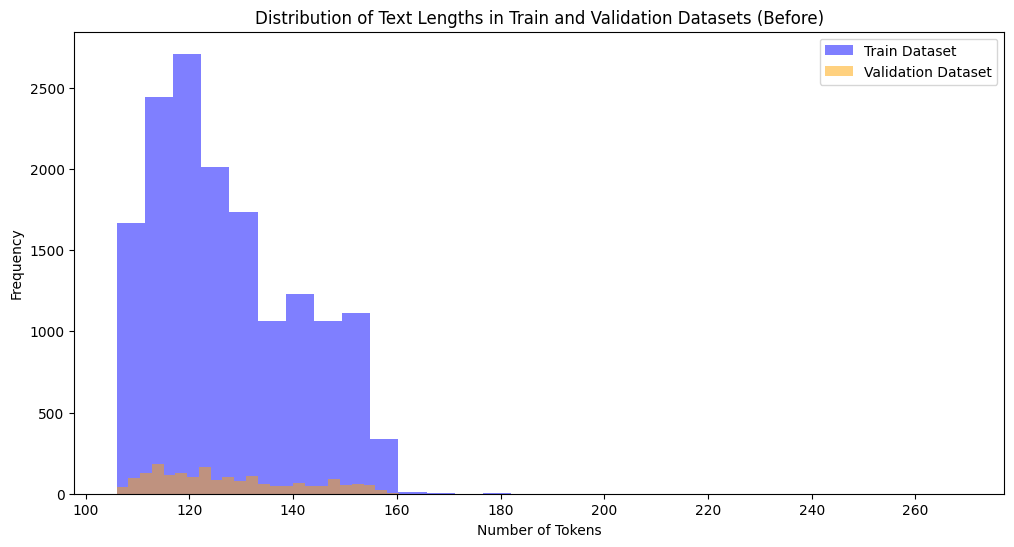

Time to EDA: 1.522 sec.


In [6]:
# Function to calculate text lengths and percentiles
def calculate_text_lengths_and_percentiles(dataset):
    text_lengths = [len(text['formatted_text'].split()) for text in dataset]
    return text_lengths, np.percentile(text_lengths, 95)  # Return lengths and the 95th percentile

# Visualization function to plot token length distributions
def plot_token_lengths(train_text_lengths, eval_text_lengths, title_suffix):
    plt.figure(figsize=(12, 6))
    plt.hist(train_text_lengths, bins=30, alpha=0.5, label="Train Dataset", color='blue')
    plt.hist(eval_text_lengths, bins=30, alpha=0.5, label="Validation Dataset", color='orange')
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Text Lengths in Train and Validation Datasets ({title_suffix})")
    plt.legend(loc="upper right")
    plt.show()

# Calculate lengths and percentiles for train and validation datasets
train_text_lengths, train_95th_percentile = calculate_text_lengths_and_percentiles(train_dataset)
eval_text_lengths, eval_95th_percentile = calculate_text_lengths_and_percentiles(eval_dataset)

# Define thresholds based on average lengths
train_threshold = int(train_95th_percentile)
eval_threshold = int(eval_95th_percentile)

# Print suggested max_seq_length
print(f"Suggested max_seq_length: {train_threshold} (Train), {eval_threshold} (Validation)")

# Plot distributions filtering
plot_token_lengths(train_text_lengths, eval_text_lengths, 'Before')

# Measure and print the time taken to prepare the model and tokenizer
time_end = time()
print(f"Time to EDA: {round(time_end - time_start, 3)} sec.")

# Training

In [7]:
peft_config = LoraConfig(
        r=64,
        lora_alpha=128,
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.SEQ_2_SEQ_LM, # FLAN-T5
        target_modules= ["q", "v"]
)

# Initialize the SFTTrainer with formatted datasets and callbacks
training_args = TrainingArguments(
        output_dir="./results_flan_t5_sft/",
        overwrite_output_dir=True,
        evaluation_strategy="steps",
        do_eval=True,
        optim="paged_adamw_8bit",
        lr_scheduler_type="linear",
        log_level="info",
        logging_steps=100,
        learning_rate=2e-5,
        eval_steps=100,
        max_steps=600,
        warmup_steps=100,
        load_best_model_at_end = True,
        save_total_limit=1,
        per_device_train_batch_size=128,
        gradient_accumulation_steps=1,
        per_device_eval_batch_size=256,
        push_to_hub=True,  # Enable automatic pushing to Hugging Face
        hub_model_id=f"{username}/{repository_name}",
        report_to="wandb"
)

In [8]:
# Define a function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)  # Convert logits to predicted class IDs

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')  # Use 'macro' or 'micro' for multi-class
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }


# Initialize the SFTTrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="formatted_text",
    peft_config=peft_config,
    args=training_args,
    tokenizer=tokenizer,
    max_seq_length=10,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3,
            early_stopping_threshold=0.01,
        )
    ],
)

# Start training
trainer.train()

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
***** Running training *****
  Num examples = 15,383
  Num Epochs = 5
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 600
  Number of trainable parameters = 7,077,888
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: iamhardikat11. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
100,340.007100,182.698898
200,137.003000,64.885841
300,60.629300,4.422588
400,20.732800,0.193704
500,6.488100,0.000000
600,3.447000,0.000000



***** Running Evaluation *****
  Num examples = 1922
  Batch size = 256
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.

***** Running Evaluation *****
  Num examples = 1922
  Batch size = 256

***** Running Evaluation *****
  Num examples = 1922
  Batch size = 256

***** Running Evaluation *****
  Num examples = 1922
  Batch size = 256

***** Running Evaluation *****
  Num examples = 1922
  Batch size = 256
Saving model checkpoint to ./results_flan_t5_sft/checkpoint-500
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,


TrainOutput(global_step=600, training_loss=94.71788182576498, metrics={'train_runtime': 320.9445, 'train_samples_per_second': 239.294, 'train_steps_per_second': 1.869, 'total_flos': 940878023270400.0, 'train_loss': 94.71788182576498, 'epoch': 4.958677685950414})

# Plot of Training and Eval Loss

In [9]:
logs = trainer.state.log_history
# Initialize pairs using list comprehensions
loss_pairs = [(log['loss'], log.get('step')) for log in logs if 'loss' in log]
eval_loss_pairs = [(log['eval_loss'], log.get('step')) for log in logs if 'eval_loss' in log]
grad_norm_pairs = [(log['grad_norm'], log.get('step')) for log in logs if 'grad_norm' in log]
lr_pairs = [(log['learning_rate'], log.get('step')) for log in logs if 'learning_rate' in log]

# Extract values
train_losses, eval_losses, grad_norms, learning_rates, steps = (
    [loss for loss, _ in loss_pairs],
    [eval_loss for eval_loss, _ in eval_loss_pairs],
    [grad_norm for grad_norm, _ in grad_norm_pairs],
    [lr for lr, _ in lr_pairs],
    [step for _, step in loss_pairs]
)

print("Log Data Loaded!")

Log Data Loaded!


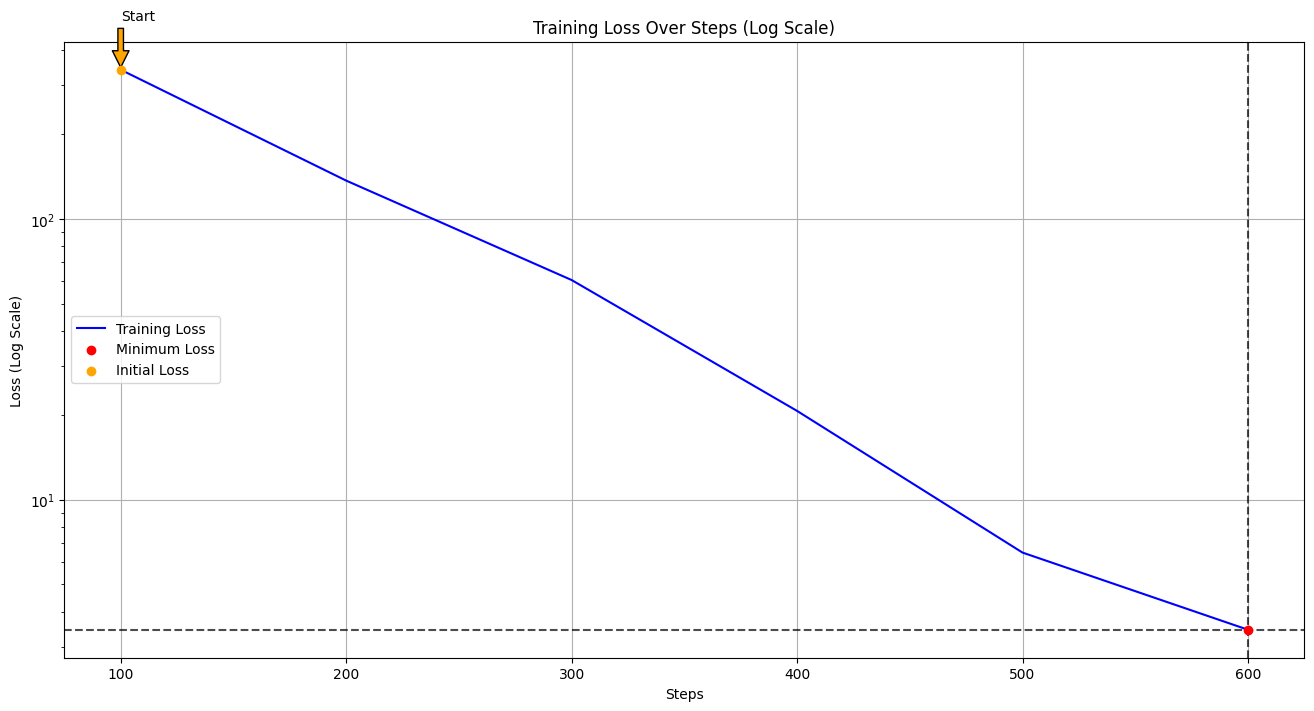

In [10]:
# Plot for Training Loss
plt.figure(figsize=(16, 8))
plt.plot(steps, train_losses, label='Training Loss', color='blue')
# Use a logarithmic scale
plt.yscale('log')

# Find minima
train_min_index = np.argmin(train_losses)
train_min_value = train_losses[train_min_index]
plt.scatter(steps[train_min_index], train_min_value, color='red', zorder=5, label='Minimum Loss')  # Minimum point
plt.axvline(x=steps[train_min_index], color='black', linestyle='--', alpha=0.7)  # Vertical line
plt.axhline(y=train_min_value, color='black', linestyle='--', alpha=0.7)  # Horizontal line

# Highlight initial and significant points
plt.scatter(steps[0], train_losses[0], color='orange', zorder=5, label='Initial Loss')  # Initial point
plt.annotate('Start', xy=(steps[0], train_losses[0]), xytext=(steps[0], train_losses[0] * 1.5),
             arrowprops=dict(facecolor='orange', shrink=0.05))

# Add title and labels
plt.title('Training Loss Over Steps (Log Scale)')
plt.xlabel('Steps')
plt.ylabel('Loss (Log Scale)')
plt.legend()
plt.grid(True)
plt.show()

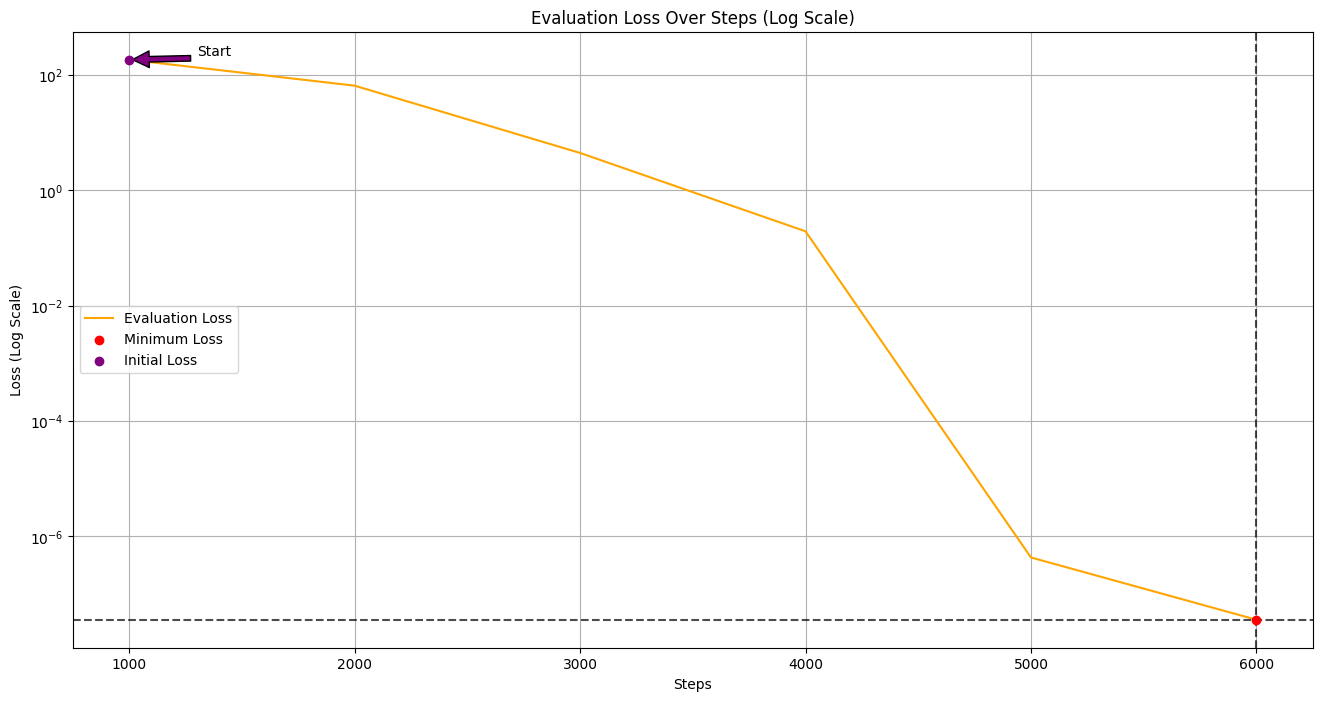

In [11]:
# Plot for Evaluation Loss
plt.figure(figsize=(16, 8))
eval_steps = [step * 10 for step in steps[:len(eval_losses)]]
plt.plot(eval_steps, eval_losses, label='Evaluation Loss', color='orange')

# Use a logarithmic scale if needed
plt.yscale('log')

# Find minima
eval_min_index = np.argmin(eval_losses)
eval_min_value = eval_losses[eval_min_index]
plt.scatter(eval_steps[eval_min_index], eval_min_value, color='red', zorder=5, label='Minimum Loss')  # Minimum point
plt.axvline(x=eval_steps[eval_min_index], color='black', linestyle='--', alpha=0.7)  # Vertical line
plt.axhline(y=eval_min_value, color='black', linestyle='--', alpha=0.7)  # Horizontal line

# Highlight initial evaluation loss point
plt.scatter(eval_steps[0], eval_losses[0], color='purple', zorder=5, label='Initial Loss')  # Initial point
plt.annotate('Start', xy=(eval_steps[0], eval_losses[0]), 
             xytext=(eval_steps[0] + (eval_steps[-1] * 0.05), eval_losses[0] * 1.2),
             arrowprops=dict(facecolor='purple', shrink=0.05))

# Add title and labels
plt.title('Evaluation Loss Over Steps (Log Scale)')
plt.xlabel('Steps')
plt.ylabel('Loss (Log Scale)')
plt.legend()
plt.grid(True)
plt.show()

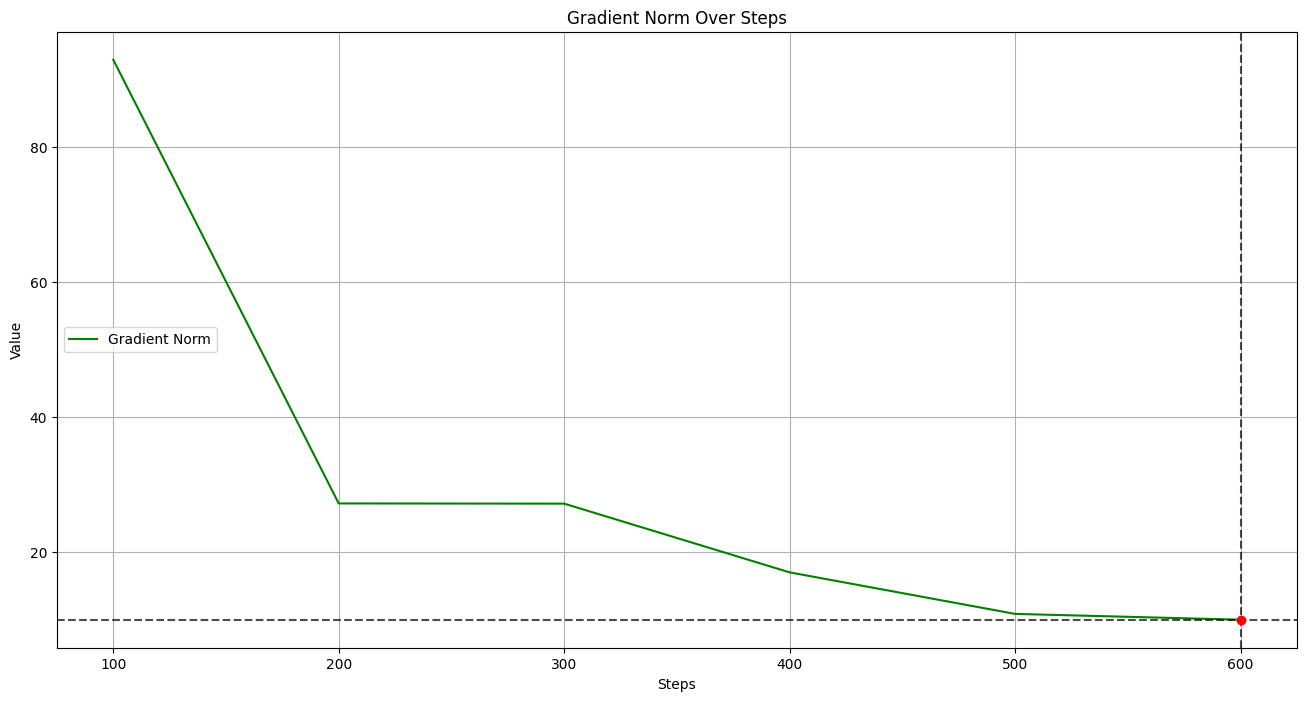

In [12]:
# Plot for Gradient Norm
plt.figure(figsize=(16, 8))
plt.plot(steps, grad_norms, label='Gradient Norm', color='green')
# Find minima
grad_norm_min_index = np.argmin(grad_norms)
grad_norm_min_value = grad_norms[grad_norm_min_index]
plt.scatter(steps[grad_norm_min_index], grad_norm_min_value, color='red', zorder=5)  # Minimum point
plt.axvline(x=steps[grad_norm_min_index], color='black', linestyle='--', alpha=0.7)  # Vertical line
plt.axhline(y=grad_norm_min_value, color='black', linestyle='--', alpha=0.7)  # Horizontal line
plt.title('Gradient Norm Over Steps')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

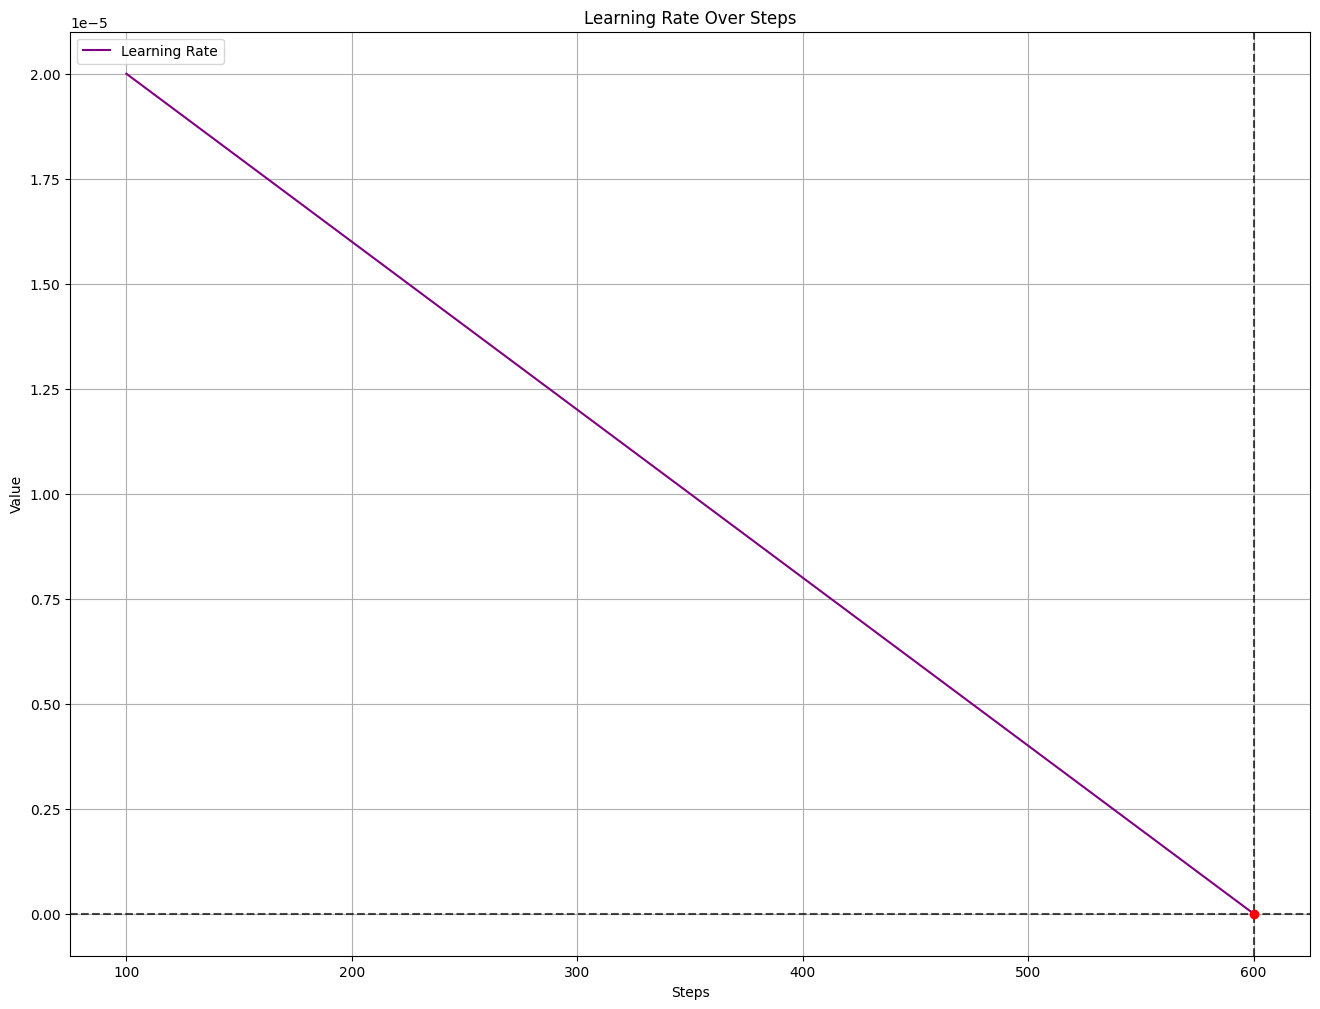

In [13]:
# Plot for Learning Rate
plt.figure(figsize=(16, 12))
plt.plot(steps, learning_rates, label='Learning Rate', color='purple')
# Find minima (not applicable for learning rate, take first min or similar)
lr_min_index = np.argmin(learning_rates)
lr_min_value = learning_rates[lr_min_index]
plt.scatter(steps[lr_min_index], lr_min_value, color='red', zorder=5)  # Minimum point
plt.axvline(x=steps[lr_min_index], color='black', linestyle='--', alpha=0.7)  # Vertical line
plt.axhline(y=lr_min_value, color='black', linestyle='--', alpha=0.7)  # Horizontal line
plt.title('Learning Rate Over Steps')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Evaluating Fine-Tuned LLM

In [14]:
# Load PEFT config and base model
config = PeftConfig.from_pretrained(f"{username}/{repository_name}")
base_model_name = "google/flan-t5-base"
test_dataset = pd.read_csv(test_path, sep='\t', header=None, names=col_names)

# Load tokenizer and determine the vocab size
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer_vocab_size = len(tokenizer)
print("Tokenizer vocab size:", tokenizer_vocab_size)

# Load base model and resize its embeddings to match tokenizer vocab size
base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name, device_map="auto")
base_model.resize_token_embeddings(tokenizer_vocab_size)

# Load PEFT adapter model with ignore_mismatched_sizes enabled
base_model = PeftModel.from_pretrained(
    model=base_model, 
    model_id=f"{username}/{repository_name}", 
    ignore_mismatched_sizes=True  # Force loading despite size mismatch
)

# Merge adapters into the base model and save
base_model = base_model.merge_and_unload()
base_model.save_pretrained("merged_adapters")
print("Model and adapters successfully merged and saved.")

adapter_config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/spiece.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/config.json
Model config T5Config {
  "_name_or_path": "google/flan-t5-base",
  "architectures":

Tokenizer vocab size: 32100


All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at google/flan-t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/generation_config.json
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32100. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to th

adapter_model.safetensors:   0%|          | 0.00/226M [00:00<?, ?B/s]

Configuration saved in merged_adapters/config.json
Configuration saved in merged_adapters/generation_config.json
Model weights saved in merged_adapters/model.safetensors


Model and adapters successfully merged and saved.


In [17]:
class ZeroShotPrompting:
    def __init__(self, tokenizer, model, output_dir, test_ds):
        self.output_dir = output_dir
        self.test_ds = test_ds
        self.tokenizer = tokenizer
        self.model = model
        os.makedirs(self.output_dir, exist_ok=True)
   
    def generate_prompt(self, post_text):
        return f"""
Classify the "Input" statement into one of these 3 categories:
normal : A normal statement, does not incite hate or offense towards a group of people.
hatespeech : A targeted statement aimed at provoking hatred or intending to cause harm towards a particular group of people based on factors such as religion, sexual orientation, caste.
offensive : A targeted statement which might be judged as demeaning by a group of people. The statement might not be hateful or aim to incite violence, though.

Based on these definitions, classify the following statement (use only one of the 3 categories as the answer):
Input: {post_text}
Label: 
        """

    def predict(self, post_text):
        # Generate input text prompt
        input_text = self.generate_prompt(post_text)

        # Tokenize input text and move tensors to the appropriate device
        input_ids = self.tokenizer(
            input_text, 
            return_tensors="pt", 
            truncation=True, 
            max_length=512  # Adjust based on model's max input length
        ).input_ids.to(self.model.device)

        # Generate the model's output sequence
        outputs = self.model.generate(input_ids)

        # Decode the output to obtain text prediction
        pred_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Map the generated text to a label
        label_map = {"normal": "normal", "hatespeech": "hatespeech", "offensive": "offensive"}
        return label_map.get(pred_text.lower().strip(), "offensive")  # Default to "unknown" if unmatched

    def apply_prediction(self):
        results = []
        correct_predictions = 0  # Initialize correct predictions counter
        total_samples = 0  # Initialize total samples counter

        # Process each post and update the progress bar with live accuracy
        with tqdm(self.test_ds.iterrows(), desc="Processing Posts", total=len(self.test_ds)) as tepoch:
            for index, (index, row) in enumerate(tepoch):
                post_text = row['post_text']
                true_label = row['sentiment_label'].lower().strip()
                predicted_label = self.predict(post_text)
                match = true_label == predicted_label
                results.append({
                    'post_text': post_text,
                    'true_label': true_label,
                    'predicted_label': predicted_label,
                    'match': match
                })

                # Update the count of correct predictions
                if match:
                    correct_predictions += 1
                
                # Increment the total samples processed
                total_samples += 1

                # Calculate and display the live accuracy
                current_accuracy = correct_predictions / total_samples if total_samples > 0 else 0
                tepoch.set_postfix(current_accuracy=f"{current_accuracy * 100:.2f}%")

        self.results_df = pd.DataFrame(results)
        results_file_path = os.path.join(self.output_dir, 'predictions_results.csv')
        self.results_df.to_csv(results_file_path, index=False)
        return self.results_df

    def accuracy_score(self):
        accuracy = accuracy_score(self.results_df['true_label'], self.results_df['predicted_label'])
        print(f"Accuracy: {accuracy * 100:.2f}%")

    def f1_score(self):
        f1 = f1_score(self.results_df['true_label'], self.results_df['predicted_label'], average='macro')
        print(f"Macro F1 Score: {f1:.2f}")

    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.results_df['true_label'], self.results_df['predicted_label'], 
                              labels=['normal', 'hatespeech', 'offensive'])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Normal', 'Hatespeech', 'Offensive'], 
                    yticklabels=['Normal', 'Hatespeech', 'Offensive'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.savefig(os.path.join(self.output_dir, 'confusion_matrix.png'))
        plt.show()

    def plot_correct_wrong(self):
        correct_wrong_summary = self.results_df.groupby(['true_label', 'match']).size().unstack(fill_value=0)
        correct_wrong_summary.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8, 6))
        plt.title('Correct vs Wrong Predictions per Label')
        plt.xlabel('True Sentiment Label')
        plt.ylabel('Count')
        plt.legend(['Wrong', 'Correct'])
        plt.savefig(os.path.join(self.output_dir, 'correct_wrong_predictions.png'))
        plt.show()

In [18]:
zsp = ZeroShotPrompting(tokenizer, base_model, output_dir=output_dir+"flan-t5-bs-fine-tuned-zero-shot", test_ds=test_dataset)
result = zsp.apply_prediction()

Processing Posts: 100%|██████████| 1924/1924 [02:25<00:00, 13.26it/s, current_accuracy=51.72%]


In [19]:
zsp.accuracy_score()

Accuracy: 51.72%


In [20]:
zsp.f1_score()

Macro F1 Score: 0.49


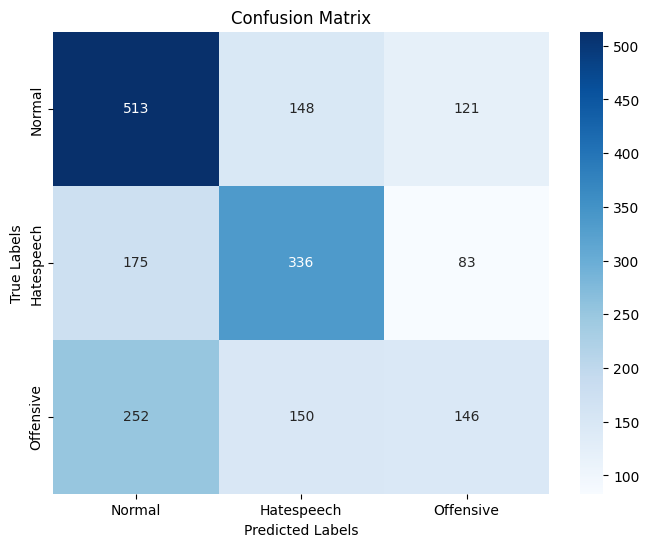

In [21]:
zsp.plot_confusion_matrix()

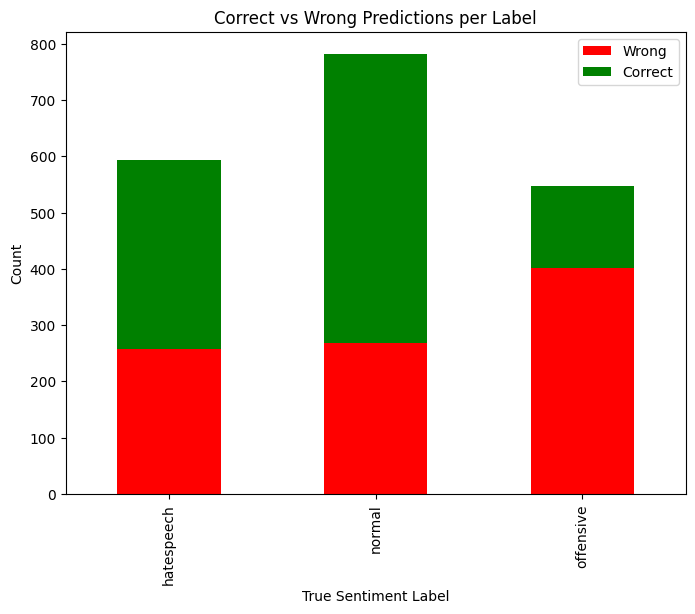

In [22]:
zsp.plot_correct_wrong()